Here we find a hyperplane that seperates the positive and the negative points as widely as possible.
                     When a hyperplane seperates our positive and negative points,we measure the distance between the nearest positive and the nearest negativw points from our hyperplane. This distance is known as the margin between the positive and the negative points. As the margin increases, the accuraccy increases.
                     
                     -------------------------------------------------------------------

If we pass planes through the nearest positive and negative points from the hyperplane, then those planes are known as SUPPORT VECTORS. 

In [1]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3






# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return -1
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


Data Cleansing : deduplication
---------------------------------------------

(1) It is based more on how we observe or interpret the data. 
(2) Basically it is cleaning or filtering the data.

we don't want to feed grbage to our model.. Do we?
--------------------------------------------------------------------------
So we remove duplicates from our entry

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


 1    307061
-1     57110
Name: Score, dtype: int64

How to convert Text to Vector?? Text Preprocessing: Stemming, stop-word removal and Lemmatization.
-------------



Here, we determine a review by score. But what if a user had mistakernly put a 5 star review but was not at all satisfied with the product? We might find such cases so the most importrant factor in determining the outcome of a review is either the text of the review or the summary text.

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative review


In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'to', 'who', 'why', 'as', 'from', 'here', 'when', 'because', 'until', 'there', "that'll", 'be', 'each', 'my', "haven't", 'that', 'same', 'very', 'you', 'yours', 'did', 'into', 'too', 'herself', 'its', "don't", 'mustn', 'which', 'his', 'are', 'whom', 'the', 'him', 'this', 'most', 'such', "she's", 'having', 'through', 'by', 'wasn', 'has', 'once', 'hasn', 'i', "you'd", 'yourselves', 'm', 'for', 'your', "weren't", 'needn', "should've", 've', 'a', 'hadn', "needn't", 'down', 'shouldn', 'me', 'after', "shan't", "you'll", 'doing', 'it', 'with', "doesn't", 'than', 'what', 'an', 'about', 'where', 'if', 'other', 'then', 'd', 'weren', 'while', 'not', 'll', 'had', 'out', 'just', 'no', "you're", 'does', 'should', 'being', 'and', 'don', 'aren', 'hers', "won't", "wouldn't", 'yourself', 'but', 'haven', 'above', 'ain', 'again', 'himself', 'he', 'only', 'some', 'didn', 'our', 'is', 'am', 'below', "aren't", 'those', 'nor', 'between', 'up', 'own', 'isn', 'will', 'themselves', 'all', 'wouldn', "didn't", 'w

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase


i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,young boy describ use chicken soup rice month ...
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,1,1291075200,good for children,"Classic children's book, can't go wrong. I rea...",classic children book cant wrong read kid orde...


In [15]:
X = final['CleanedText']
X.head()


138706    witti littl book make son laugh loud recit car...
138705    young boy describ use chicken soup rice month ...
138699    classic children book cant wrong read kid orde...
138680    wonder littl book love year ago twin love enjo...
138689    fun way children learn month year learn poem t...
Name: CleanedText, dtype: object

In [16]:
Y = final['Score']
Y.head()

138706    1
138705    1
138699    1
138680    1
138689    1
Name: Score, dtype: int64

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (291336,)
Test Data Size:  (72835,)


In [20]:
print("Train Data Size: ",Y_train.shape)
print("Test Data Size: ",Y_test.shape)

Train Data Size:  (291336,)
Test Data Size:  (72835,)


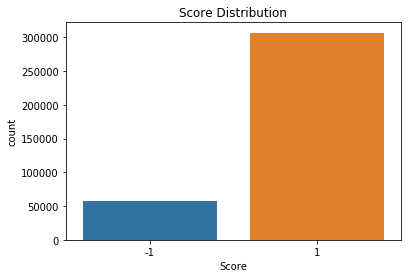

In [21]:
ax = plt.axes()
sns.countplot(final.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()



# SGD with ' Hinge Loss' :

Bag Of Words (BoW) :
-----------

Bag of Words constructs a dictionsry of all the words in the document. A corpous is defined as a set of documents/reviews.
It converts all the words in the document into a vector each word having a different dimension. Each cell in the vector corresponds to the no of times a word occurs in the document.
 Similar texts result in closer distances between two vectors. Although BoW has its own limitations.


 Train:
 -------

In [22]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (291336, 64187)
the number of unique words  64187


In [23]:
X_train_bow = preprocessing.normalize(X_train_bow)
X_test_bow = preprocessing.normalize(X_test_bow)

In [24]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
    print(X_train_bow[train].shape, X_train_bow[cv].shape)

(26486, 64187) (26485, 64187)
(52971, 64187) (26485, 64187)
(79456, 64187) (26485, 64187)
(105941, 64187) (26485, 64187)
(132426, 64187) (26485, 64187)
(158911, 64187) (26485, 64187)
(185396, 64187) (26485, 64187)
(211881, 64187) (26485, 64187)
(238366, 64187) (26485, 64187)
(264851, 64187) (26485, 64187)


In [25]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from datetime import datetime
from sklearn.metrics import roc_auc_score

In [26]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report


In [27]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")


In [28]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
from sklearn.model_selection import cross_val_score
from datetime import datetime
from sklearn.metrics import roc_auc_score

In [31]:
from sklearn.linear_model import SGDClassifier

<h3> Accuracy as metric with grid and random search CV </h3>

In [78]:
start = datetime.now()
from sklearn import linear_model
clf_grid = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced")
tuned_parameters = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_grid = GridSearchCV(clf_grid, tuned_parameters, cv = tscv, n_jobs =-1, scoring = 'accuracy')
model_grid.fit(X_train_bow, Y_train)
print(model_grid.best_estimator_)
print(model_grid.score(X_test_bow, Y_test))


print("Best HyperParameter with grid search & with accuracy as metric is: ",model_grid.best_params_)
print("Best Accuracy with Grid search & with accuracy as metric is: %.2f%%"%(model.best_score_*100))

print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8680853985034668
Best HyperParameter with grid search & with accuracy as metric is:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy with Grid search & with accuracy as metric is: 86.26%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:42.271232
------------------------------------------------------------------------


In [79]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'accuracy')
model_rnd.fit(X_train_bow,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_bow, Y_test))



print("Best HyperParameter with random search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8632388274867852
Best HyperParameter with random search & with accuracy as metric:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy random search & with accuracy as metric: 86.68%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:42.910068
------------------------------------------------------------------------


<h3> Gridsearch & random search</h3>

<h5> *As the hyperparameters of my grid and randomsearch are same, i did it all at once* </h5>

Accuracy on test set: 86.236%
Macro F1-Score on test set: 0.791
Micro F1-Score on test set: 0.862
Weighted F1-Score on test set: 0.875
roc_auc Score on test set: 0.870
Precision on test set: 0.975
Recall on test set: 0.859
Error : 13.764%
Hinge loss : 0.2752797418823368
Precision recall report :
               precision    recall  f1-score   support

          -1       0.54      0.88      0.67     11434
           1       0.97      0.86      0.91     61401

   micro avg       0.86      0.86      0.86     72835
   macro avg       0.76      0.87      0.79     72835
weighted avg       0.91      0.86      0.87     72835

TPR is 0.8588133743750102
TNR is 0.8814063319923037
FPR is 0.11859366800769634
FNR is 0.14118662562498982

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:57.117256
------------------------------------------------------------------------


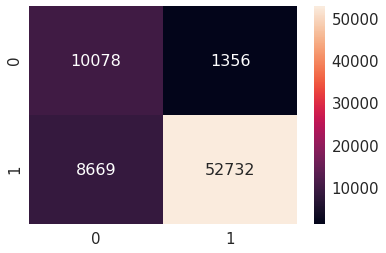

In [80]:


clf = linear_model.SGDClassifier(alpha = 0.0001, penalty ='l2',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

In [ ]:
y = PrettyTable()



y.field_names = ["S.R.","Vectorizer", "Algorithm", "alpha",'Accuracy', "F-1 score", "Precision", "Recall"]

y.add_row(["(1)","BoW", "SGD", 25, '86.087%', 0.536, 0.860, 0.539])
y.add_row(["(2)","BoW", "SGD", 23, '85.100%', 0.465, 0.726, 0.502])


print(y.get_string(title = "<<----------------------TEST DATA---------------------->>"))


z = PrettyTable()

z.field_names = ["S.R.","Vectorizer", "Algorithm", "K",'Accuracy', "F-1 score", "Precision", "Recall"]

z.field_names = ["S.R.","Vectorizer", "Algorithm", "K",'Accuracy', "F-1 score", "Precision", "Recall"]

z.add_row(["(1)","BoW", "brute", 11, '86.275%', 0.545, 0.809, 0.546])
z.add_row(["(2)","BoW", "kd_tree", 21, '84.225%', 0.459, 0.671, 0.501])



print(z.get_string(title = "<<----------------------CROSS VALIDATE DATA---------------------->>"))






In [81]:
all_feat = count_vect.get_feature_names()

In [82]:
def show_most_informative_features(vectorizer, clf, n= 25):
    feature_names = all_feat
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))
        
show_most_informative_features(X,clf)


#Source : https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

		Positive					Negative
________________________________________________________________________________________________ 

	4.3769	delici         				-4.6871	disappoint     
	4.1964	best           				-3.7436	worst          
	4.1516	great          				-3.3206	aw             
	4.0653	perfect        				-3.2909	unfortun       
	3.9855	excel          				-3.1196	terribl        
	3.2092	amaz           				-2.9707	horribl        
	3.1970	love           				-2.9097	bland          
	3.0318	nice           				-2.8961	return         
	2.9933	favorit        				-2.7066	weak           
	2.7650	awesom         				-2.6899	stale          
	2.6092	smooth         				-2.5229	wast           
	2.5761	easi           				-2.4203	thought        
	2.5343	wonder         				-2.3657	bad            
	2.4984	yummi          				-2.3441	sorri          
	2.4858	addict         				-2.3427	disgust        
	2.4547	tasti          				-2.3144	money          
	2.4259	happi          				-2.2678	mayb           
	2.3923	gl

<h3> with f1 as metric </h3>

In [83]:
start = datetime.now()
from sklearn import linear_model
clf_grid = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced")
tuned_parameters = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_grid = GridSearchCV(clf_grid, tuned_parameters, cv = tscv, n_jobs =-1, scoring = 'f1')
model_grid.fit(X_train_bow, Y_train)
print(model_grid.best_estimator_)
print(model_grid.score(X_test_bow, Y_test))


print("Best HyperParameter with grid search & with accuracy as metric is: ",model_grid.best_params_)
print("Best Accuracy with Grid search & with accuracy as metric is: %.2f%%"%(model.best_score_*100))

print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9179072368987179
Best HyperParameter with grid search & with accuracy as metric is:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy with Grid search & with accuracy as metric is: 86.26%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:44.871969
------------------------------------------------------------------------


In [91]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'f1')
model_rnd.fit(X_train_bow,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_bow, Y_test))



print("Best HyperParameter with random search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=10000, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9148216573795406
Best HyperParameter with random search & with accuracy as metric:  {'penalty': 'l1', 'alpha': 10000}
Best Accuracy random search & with accuracy as metric: 91.52%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:45.752778
------------------------------------------------------------------------


Accuracy on test set: 84.302%
Macro F1-Score on test set: 0.457
Micro F1-Score on test set: 0.843
Weighted F1-Score on test set: 0.771
roc_auc Score on test set: 0.500
Precision on test set: 0.843
Recall on test set: 1.000
Error : 15.698%
Hinge loss : 0.3139699320381685
Precision recall report :
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00     11434
           1       0.84      1.00      0.91     61401

   micro avg       0.84      0.84      0.84     72835
   macro avg       0.42      0.50      0.46     72835
weighted avg       0.71      0.84      0.77     72835

TPR is 1.0
TNR is 0.0
FPR is 1.0
FNR is 0.0

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:52.958975
------------------------------------------------------------------------


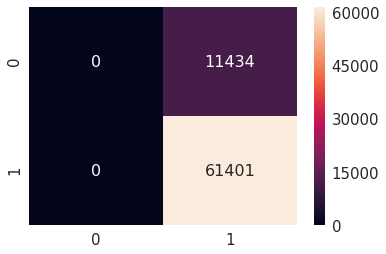

In [92]:
clf = linear_model.SGDClassifier(alpha = 10000, penalty ='l1',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

change the scoring asap to roc_auc

In [93]:
start = datetime.now()
from sklearn import linear_model
clf_grid = linear_model.SGDClassifier(loss='hinge', n_jobs = -1, class_weight = "balanced")
tuned_parameters = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_grid = GridSearchCV(clf_grid, tuned_parameters, cv = tscv, n_jobs =-1, scoring = 'roc_auc')
model_grid.fit(X_train_bow, Y_train)
print(model_grid.best_estimator_)
print(model_grid.score(X_test_bow, Y_test))


print("Best HyperParameter with grid search & with accuracy as metric is: ",model_grid.best_params_)
print("Best Accuracy with Grid search & with accuracy as metric is: %.2f%%"%(model.best_score_*100))

print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9429952410526206
Best HyperParameter with grid search & with accuracy as metric is:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy with Grid search & with accuracy as metric is: 86.26%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:41.884959
------------------------------------------------------------------------


In [94]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'roc_auc')
model_rnd.fit(X_train_bow,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_bow, Y_test))



print("Best HyperParameter with random search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9430799889115878
Best HyperParameter with random search & with accuracy as metric:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy random search & with accuracy as metric: 94.13%

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:43.745082
------------------------------------------------------------------------


ok so the random search with f1 as metric gave me a dumb model

TfIDF combination:
------------
 
    The main objective here is to give weightage to words which are rare in a corpus but are more important, that is occur more frequently in my document
    
                    TF(W,R)*IDF(W,D)

In [95]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train_tf = tf_idf_vect.fit_transform(X_train.values)
X_test_tf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (291336, 2542442)
the number of unique words including both unigrams and bigrams  2542442


In [96]:
X_train_tf = preprocessing.normalize(X_train_tf)

X_test_tf = preprocessing.normalize(X_test_tf)

In [97]:
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tf):
    print(X_train_tf[train].shape, X_train_tf[cv].shape)


(26486, 2542442) (26485, 2542442)
(52971, 2542442) (26485, 2542442)
(79456, 2542442) (26485, 2542442)
(105941, 2542442) (26485, 2542442)
(132426, 2542442) (26485, 2542442)
(158911, 2542442) (26485, 2542442)
(185396, 2542442) (26485, 2542442)
(211881, 2542442) (26485, 2542442)
(238366, 2542442) (26485, 2542442)
(264851, 2542442) (26485, 2542442)


In [105]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'accuracy')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))



print("Best HyperParameter with Grid search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'f1')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))

print("Best HyperParameter with Grid search & with f1 as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with f1 as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'roc_auc')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))


print("Best HyperParameter with Grid search & with roc_auc as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with roc_auc as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8823642479577126
Best HyperParameter with Grid search & with accuracy as metric:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy Grid search & with accuracy as metric: 88.72%

------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=

In [103]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'accuracy')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))



print("Best HyperParameter with random search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'f1')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))

print("Best HyperParameter with random search & with f1 as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with f1 as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = RandomizedSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'roc_auc')
model_rnd.fit(X_train_tf,Y_train)


print(model_rnd.best_estimator_)
print(model_rnd.score(X_test_tf, Y_test))


print("Best HyperParameter with random search & with roc_auc as metric: ",model_rnd.best_params_)
print("Best Accuracy random search & with roc_auc as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.8810324706528455
Best HyperParameter with random search & with accuracy as metric:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy random search & with accuracy as metric: 88.67%

------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, 

Accuracy on test set: 86.630%
Macro F1-Score on test set: 0.795
Micro F1-Score on test set: 0.866
Weighted F1-Score on test set: 0.878
roc_auc Score on test set: 0.871
Precision on test set: 0.974
Recall on test set: 0.864
Error : 13.370%
Hinge loss : 0.267398915356628
Precision recall report :
               precision    recall  f1-score   support

          -1       0.55      0.88      0.67     11434
           1       0.97      0.86      0.92     61401

   micro avg       0.87      0.87      0.87     72835
   macro avg       0.76      0.87      0.79     72835
weighted avg       0.91      0.87      0.88     72835

TPR is 0.8643507434732334
TNR is 0.8767710337589645
FPR is 0.1232289662410355
FNR is 0.13564925652676665

------------------------------------------------------------------------
Time taken to run this cell :
 0:04:08.795373
------------------------------------------------------------------------


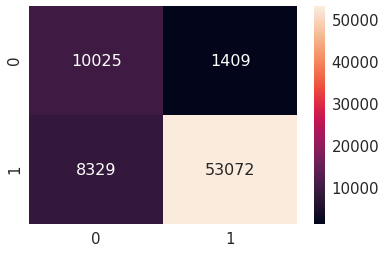

In [100]:
clf = linear_model.SGDClassifier(alpha = 0.0001, penalty ='l2',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

In [106]:
show_most_informative_features(X,clf)

		Positive					Negative
________________________________________________________________________________________________ 

	5.9762	delici         				-10.5439	cancel         
	5.9505	perfect        				-8.4675	worst          
	5.8604	excel          				-7.5759	aw             
	5.3387	amaz           				-7.4451	horribl        
	5.1491	best           				-6.2428	terribl        
	4.9516	great          				-6.1004	disappoint     
	4.8855	awesom         				-6.0780	refund         
	4.6665	addict         				-5.9540	unfortun       
	4.5468	yummi          				-5.2073	return         
	4.5154	fantast        				-4.9775	gelatin        
	4.4848	beat           				-4.8545	bland          
	4.0261	smooth         				-4.7077	disgust        
	3.9808	worri          				-4.6106	poor           
	3.9347	favorit        				-4.4859	tasteless      
	3.8954	nice           				-4.4726	stale          
	3.8109	hook           				-4.3855	weak           
	3.7745	satisfi        				-3.9631	sad            
	3.7612	g

Word to vec:
------------

This technique takes the semantic meaning if word into consideration. It is very simple. Just give it a word and you will get the vector of d-dimension. If two words are similar, Then the correspondin vectors seem to be closer. For example (Vman - Vwoman) || (Vking - vqueen) It learns all relatiomships without being programmed. The more the dimensions, the larger the dimensionality. we need large data to execute it. What is basically does is, it looks at the neighbourhood for similarity.


In [107]:
from tqdm import tqdm

In [108]:
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [109]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

republ tea pineappl lyche hibiscus tea one best tea long time fragranc tea amaz tast fresh steep two bag cup hot water pour ice refresh pick late afternoon would never known well hibiscus flower pinappl fruit compliment one anoth hadnt tri tea tast beauti
*****************************************************************
['republ', 'tea', 'pineappl', 'lyche', 'hibiscus', 'tea', 'one', 'best', 'tea', 'long', 'time', 'fragranc', 'tea', 'amaz', 'tast', 'fresh', 'steep', 'two', 'bag', 'cup', 'hot', 'water', 'pour', 'ice', 'refresh', 'pick', 'late', 'afternoon', 'would', 'never', 'known', 'well', 'hibiscus', 'flower', 'pinappl', 'fruit', 'compliment', 'one', 'anoth', 'hadnt', 'tri', 'tea', 'tast', 'beauti']


In [110]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [111]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19841
sample words  ['republ', 'tea', 'pineappl', 'lyche', 'hibiscus', 'one', 'best', 'long', 'time', 'fragranc', 'amaz', 'tast', 'fresh', 'steep', 'two', 'bag', 'cup', 'hot', 'water', 'pour', 'ice', 'refresh', 'pick', 'late', 'afternoon', 'would', 'never', 'known', 'well', 'flower', 'pinappl', 'fruit', 'compliment', 'anoth', 'hadnt', 'tri', 'beauti', 'lemon', 'wafer', 'ive', 'ever', 'encount', 'glad', 'found', 'amazon', 'hard', 'find', 'local', 'introduc', 'excel']


In [188]:
print(w2v_model.wv.most_similar('like'))

[('weird', 0.6937322616577148), ('gross', 0.6328852772712708), ('think', 0.624843180179596), ('fake', 0.6220317482948303), ('besid', 0.614007830619812), ('hate', 0.6079033613204956), ('good', 0.6071311235427856), ('funki', 0.6060141324996948), ('appeal', 0.6040209531784058), ('enjoy', 0.6024390459060669)]


In [112]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


Average W2V:
---------

It is basically used for converting sentences to vectors. It takes w2v of different words and adds them, then dividing them by the no of words. It is most proably the simplest way to build a sentence vector.


In [113]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 291336/291336 [06:19<00:00, 767.27it/s]

291336
50


In [114]:
sent_vectors = preprocessing.normalize(sent_vectors)
print(sent_vectors.shape)

(291336, 50)


In [115]:
X_train_wv = sent_vectors

In [120]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'accuracy')
model_rnd.fit(X_train_wv,Y_train)


print(model_rnd.best_estimator_)



print("Best HyperParameter with Grid search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'f1')
model_rnd.fit(X_train_wv,Y_train)


print(model_rnd.best_estimator_)

print("Best HyperParameter with Grid search & with f1 as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with f1 as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'roc_auc')
model_rnd.fit(X_train_wv,Y_train)


print(model_rnd.best_estimator_)



print("Best HyperParameter with Grid search & with roc_auc as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with roc_auc as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter with Grid search & with accuracy as metric:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy Grid search & with accuracy as metric: 84.09%

------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       valida

In [126]:
i=0
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())

In [127]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 72835/72835 [01:47<00:00, 677.83it/s]

72835
50


In [128]:
X_test_wv = sent_vectors

Accuracy on test set: 86.287%
Macro F1-Score on test set: 0.791
Micro F1-Score on test set: 0.863
Weighted F1-Score on test set: 0.875
roc_auc Score on test set: 0.870
Precision on test set: 0.975
Recall on test set: 0.860
Error : 13.713%
Hinge loss : 0.2742637468250154
Precision recall report :
               precision    recall  f1-score   support

          -1       0.54      0.88      0.67     11434
           1       0.97      0.86      0.91     61401

   micro avg       0.86      0.86      0.86     72835
   macro avg       0.76      0.87      0.79     72835
weighted avg       0.91      0.86      0.88     72835

TPR is 0.859627693360043
TNR is 0.880269372048277
FPR is 0.11973062795172293
FNR is 0.140372306639957

------------------------------------------------------------------------
Time taken to run this cell :
 0:29:18.402686
------------------------------------------------------------------------


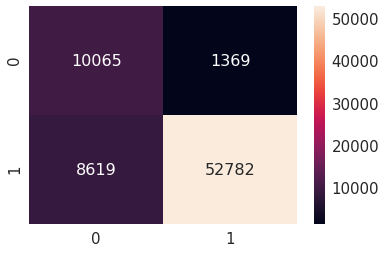

In [129]:
clf = linear_model.SGDClassifier(alpha = 0.0001, penalty ='l2',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 86.170%
Macro F1-Score on test set: 0.787
Micro F1-Score on test set: 0.862
Weighted F1-Score on test set: 0.874
roc_auc Score on test set: 0.861
Precision on test set: 0.971
Recall on test set: 0.862
Error : 13.830%
Hinge loss : 0.27659778952426717
Precision recall report :
               precision    recall  f1-score   support

          -1       0.54      0.86      0.66     11434
           1       0.97      0.86      0.91     61401

   micro avg       0.86      0.86      0.86     72835
   macro avg       0.75      0.86      0.79     72835
weighted avg       0.90      0.86      0.87     72835

TPR is 0.8619892184166381
TNR is 0.8601539268847298
FPR is 0.13984607311527025
FNR is 0.13801078158336183

------------------------------------------------------------------------
Time taken to run this cell :
 0:29:33.884140
------------------------------------------------------------------------


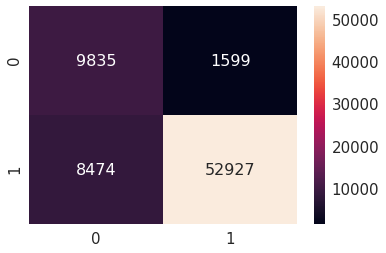

In [130]:
clf = linear_model.SGDClassifier(alpha = 0.0001, penalty ='l1',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

# tfidf weightes w2v:    ---

In [121]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [122]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 291336/291336 [07:39<00:00, 634.31it/s]


In [123]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(291336, 50)


In [124]:
X_train_twv = tfidf_sent_vectors

In [125]:
start = datetime.now()


clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'accuracy')
model_rnd.fit(X_train_twv,Y_train)


print(model_rnd.best_estimator_)



print("Best HyperParameter with Grid search & with accuracy as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with accuracy as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'f1')
model_rnd.fit(X_train_twv,Y_train)


print(model_rnd.best_estimator_)

print("Best HyperParameter with Grid search & with f1 as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with f1 as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')

clf_rnd = linear_model.SGDClassifier(loss = 'hinge', class_weight = "balanced")
param_rnd = { 'alpha': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_rnd = GridSearchCV(clf_rnd,param_rnd,cv= tscv, scoring = 'roc_auc')
model_rnd.fit(X_train_twv,Y_train)


print(model_rnd.best_estimator_)



print("Best HyperParameter with Grid search & with roc_auc as metric: ",model_rnd.best_params_)
print("Best Accuracy Grid search & with roc_auc as metric: %.2f%%"%(model_rnd.best_score_*100))


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

SGDClassifier(alpha=10, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Best HyperParameter with Grid search & with accuracy as metric:  {'alpha': 10, 'penalty': 'l2'}
Best Accuracy Grid search & with accuracy as metric: 84.36%

------------------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fra

In [131]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 72835/72835 [01:59<00:00, 610.87it/s]


In [135]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(72835, 50)


In [136]:
X_test_twv = tfidf_sent_vectors 

Accuracy on test set: 15.698%
Macro F1-Score on test set: 0.136
Micro F1-Score on test set: 0.157
Weighted F1-Score on test set: 0.043
roc_auc Score on test set: 0.500
Precision on test set: 0.000
Recall on test set: 0.000
Error : 84.302%
Hinge loss : 1.6860300679618316
Precision recall report :
               precision    recall  f1-score   support

          -1       0.16      1.00      0.27     11434
           1       0.00      0.00      0.00     61401

   micro avg       0.16      0.16      0.16     72835
   macro avg       0.08      0.50      0.14     72835
weighted avg       0.02      0.16      0.04     72835

TPR is 0.0
TNR is 1.0
FPR is 0.0
FNR is 1.0

------------------------------------------------------------------------
Time taken to run this cell :
 0:32:37.412743
------------------------------------------------------------------------


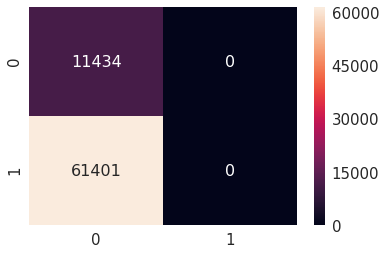

In [137]:
clf = linear_model.SGDClassifier(alpha = 10, penalty ='l2',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 86.261%
Macro F1-Score on test set: 0.788
Micro F1-Score on test set: 0.863
Weighted F1-Score on test set: 0.874
roc_auc Score on test set: 0.861
Precision on test set: 0.970
Recall on test set: 0.863
Error : 13.739%
Hinge loss : 0.2747854740166129
Precision recall report :
               precision    recall  f1-score   support

          -1       0.54      0.86      0.66     11434
           1       0.97      0.86      0.91     61401

   micro avg       0.86      0.86      0.86     72835
   macro avg       0.75      0.86      0.79     72835
weighted avg       0.90      0.86      0.87     72835

TPR is 0.8633084151723913
TNR is 0.8588420500262376
FPR is 0.14115794997376246
FNR is 0.13669158482760868

------------------------------------------------------------------------
Time taken to run this cell :
 0:32:44.311816
------------------------------------------------------------------------


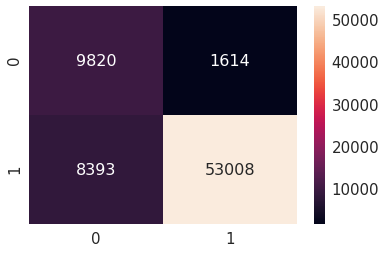

In [138]:
clf = linear_model.SGDClassifier(alpha = 0.0001, penalty ='l1',loss='hinge', n_jobs = -1, class_weight = "balanced")
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Hinge loss :",metrics.hinge_loss(Y_test,Y_pred))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')